In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from skimage.util.montage import montage2d
from skimage.io import imread
from tensorflow.python.keras.utils import to_categorical

/home/mimi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
xray_df = pd.read_csv('./input/sample_labels.csv')
xray_df.sample(4)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3597,00017716_000.png,No Finding,0,17716,062Y,F,PA,2602,2913,0.143,0.143
1824,00009608_035.png,Infiltration|Mass,35,9608,030Y,M,AP,2500,2048,0.168,0.168
2718,00013641_013.png,No Finding,13,13641,039Y,M,AP,2500,2048,0.168,0.168
2364,00011973_013.png,No Finding,13,11973,061Y,M,AP,2500,2048,0.168,0.168


In [3]:
TARGET = 'normal'
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('.', 'input', 'sample_data', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', xray_df.shape[0])
xray_df['path'] = xray_df['Image Index'].map(all_image_paths.get)
# xray_df['infiltration'] = xray_df['Finding Labels'].map(lambda x: 'Infiltration' in x)
xray_df['normal'] = xray_df['Finding Labels'].map(lambda x: 'No Finding' in x).astype(int)
xray_df['Patient Age'] = xray_df['Patient Age'].map(lambda x: int(x[:-1]))
xray_df.sample(3)

Scans found: 5606 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,normal
3562,00017618_002.png,Atelectasis,2,17618,35,M,PA,2992,2991,0.143,0.143,./input/sample_data/00017618_002.png,0
3158,00015555_000.png,Nodule,0,15555,43,M,PA,2992,2991,0.143,0.143,./input/sample_data/00015555_000.png,0
1390,00007207_003.png,No Finding,3,7207,49,F,PA,2544,3056,0.139,0.139,./input/sample_data/00007207_003.png,1


# Proprocessing Label

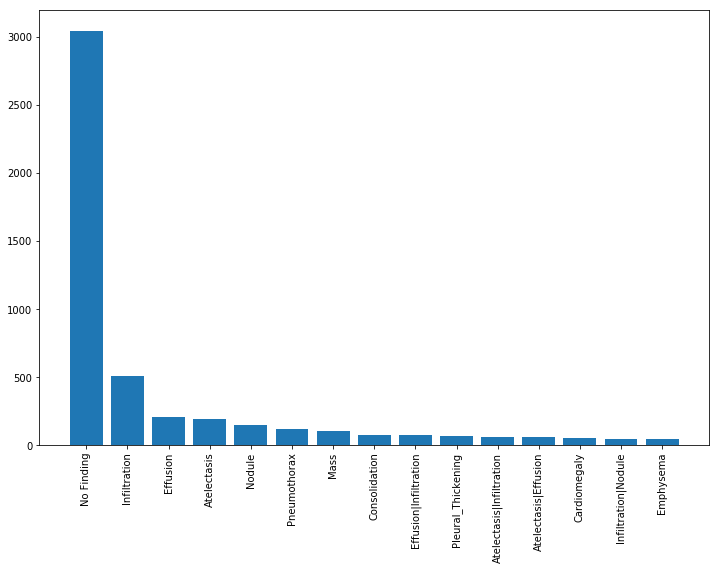

In [4]:
label_counts = xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [5]:
xray_df['Finding Labels'] = xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5505,00030026_002.png,,2,30026,58,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1240,00006519_026.png,Atelectasis|Effusion|Infiltration,26,6519,59,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1167,00006199_010.png,Atelectasis|Pneumothorax,10,6199,53,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Clean Categories

In [6]:
# # keep at least 1000 cases
# MIN_CASES = 1000
# all_labels = [c_label for c_label in all_labels if xray_df[c_label].sum() > MIN_CASES]
# print('Clean Labels ({})'.format(len(all_labels)), 
#       [(c_label,int(xray_df[c_label].sum())) for c_label in all_labels])

In [7]:
#resample biases class

In [8]:
# sample_weights = xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
# sample_weights /= sample_weights.sum()
# xray_df = xray_df.sample(40000, weights=sample_weights)

# label_counts = xray_df['Finding Labels'].value_counts()[:15]
# fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
# ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
# ax1.set_xticks(np.arange(len(label_counts))+0.5)
# _ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [9]:
# label_counts = 100*np.mean(xray_df[all_labels].values,0)
# fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
# ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
# ax1.set_xticks(np.arange(len(label_counts))+0.5)
# ax1.set_xticklabels(all_labels, rotation = 90)
# ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
# _ = ax1.set_ylabel('Frequency (%)')

# Prepare training data

In [10]:
xray_df['disease_vec'] = xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [11]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 4204 validation 1402


# create data generator

In [12]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (299, 299)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [13]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [14]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 512)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 4204 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1402 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1402 images


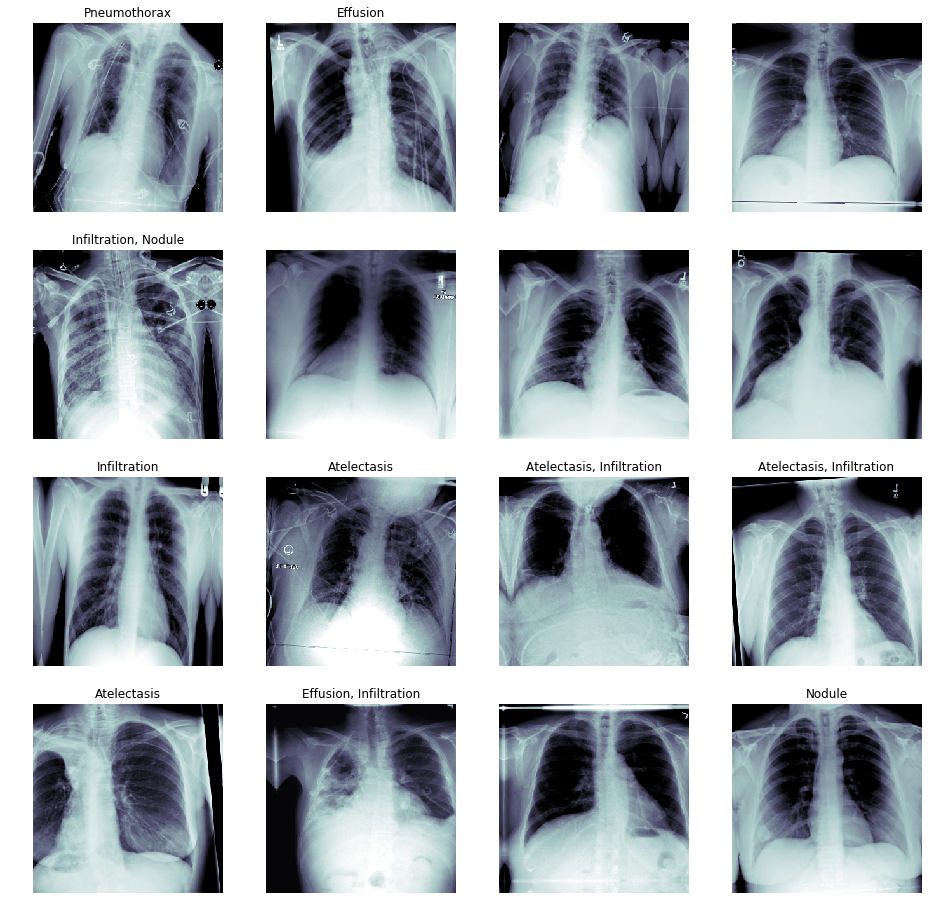

In [15]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Balance the distribution in the training set

# Pretrained Features

In [16]:
# ! pip install tqdm
from tensorflow.python.keras.applications import InceptionV3, Xception
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.python.keras.models import Sequential

from tqdm import tqdm
base_pretrained_model = Xception(input_shape =  t_x.shape[1:], include_top = False, weights = None)
# base_pretrained_model = InceptionV3(input_shape =  t_x.shape[1:], include_top = False)
multi_model = Sequential()
multi_model.add(base_pretrained_model)
multi_model.add(GlobalAveragePooling2D())
multi_model.add(Dropout(0.5))
multi_model.add(Dense(512))
multi_model.add(Dropout(0.3))
multi_model.add(Dense(len(all_labels), activation = 'softmax'))
multi_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['accuracy', 'mae'])
multi_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20860904  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                7182      
Total params: 21,917,174
Trainable params: 21,862,646
Non-trainable params: 54,528
___________________________________________________________

In [17]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="./weights.{epoch:02d}-{val_loss:.2f}.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [18]:
multi_model.fit_generator(train_gen, 
                          steps_per_epoch=10,
                          validation_data = (test_X, test_Y), 
                          epochs = 1, 
                          callbacks = callbacks_list)

Epoch 1/1
 9/10 [==========================>...] - ETA: 2:35 - loss: 2.2331 - acc: 0.1458 - mean_absolute_error: 0.1068
Epoch 00001: val_loss improved from inf to 1.95395, saving model to ./weights.01-1.95.hdf5
10/10 [==============================] - 1879s 188s/step - loss: 2.2508 - acc: 0.1375 - mean_absolute_error: 0.1074 - val_loss: 1.9540 - val_acc: 0.1270 - val_mean_absolute_error: 0.1169


In [19]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 9.77%
Cardiomegaly: 2.34%
Consolidation: 4.69%
Edema: 1.95%
Effusion: 11.33%
Emphysema: 1.76%
Fibrosis: 2.15%
Hernia: 0.59%
Infiltration: 19.92%
Mass: 6.45%
Nodule: 5.66%
Pleural_Thickening: 2.93%
Pneumonia: 0.78%
Pneumothorax: 4.10%


In [20]:
pred_Y = multi_model.predict(test_X, batch_size = 128, verbose = True)

512/512 [==============================] - 360s 703ms/step


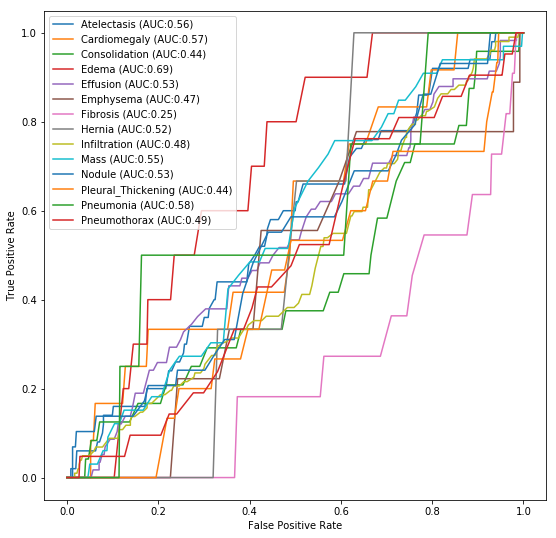

In [21]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [22]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 9.77%, PDx: 7.02%
Cardiomegaly: Dx: 2.34%, PDx: 7.15%
Consolidation: Dx: 4.69%, PDx: 7.32%
Edema: Dx: 1.95%, PDx: 7.26%
Effusion: Dx: 11.33%, PDx: 7.39%
Emphysema: Dx: 1.76%, PDx: 7.10%
Fibrosis: Dx: 2.15%, PDx: 6.95%
Hernia: Dx: 0.59%, PDx: 6.92%
Infiltration: Dx: 19.92%, PDx: 7.41%
Mass: Dx: 6.45%, PDx: 7.11%
Nodule: Dx: 5.66%, PDx: 7.10%
Pleural_Thickening: Dx: 2.93%, PDx: 7.10%
Pneumonia: Dx: 0.78%, PDx: 6.88%
Pneumothorax: Dx: 4.10%, PDx: 7.28%
